(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [2]:
# Load project package
@load_pkg BayesFitness

import Revise
import Suppressor
# Import project package
import BayesFitness
# Import library to list files
import Glob
# Import package to save chains into memory
import BSON

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import basic statistical functions
import StatsBase
import Random

# Import basic math
import LinearAlgebra

# Import libraries relevant for MCMC
import Turing
import MCMCChains

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitness.viz.pboc_makie!()

# Bayesian inference of adaptive mutants fitness

## The fitness model

`[explanation here]`

## Loading the data

Let's begin by loading the data.

In [3]:
# Load data
df = CSV.read("$(git_root())/data/big_batch/tidy_counts.csv", DF.DataFrame)

first(df, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count,rep,timepoint,time,batch,hub,perturbation,neutral
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64,String3,String3,Int64,String7,String7,String15,Bool
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53,R1,T0,0,Batch1,1Day,28,false
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213,R1,T0,0,Batch1,1Day,28,false
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17,R1,T0,0,Batch1,1Day,28,false
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19,R1,T0,0,Batch1,1Day,28,false
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23,R1,T0,0,Batch1,1Day,28,false


# Bayesian  model using `Turing.jl`

Our objective for this section will be to implement the Bayesian model using the
probabilistic programing language that `Turing.jl` encodes.

`[explanation here]`

Let's define the model using the @model macro from `Turing.jl`

In [15]:
Turing.@model function fitness_mutants(
    logf_mut, logf_neutral, t, σ_sm, σ_σm, σ_st, σ_σt
)
    # Define parameter types
    s̲ₘ = Float32[]  # adaptive mutants fitness
    σ̲ₘ = Float32[]  # variance for adaptive mutants fitness likelihood

    s̲ₜ = Float32[]  # population mean fitness vector
    σ̲ₜ = Float32[]  # variance for population mean fitness likelihood

    ## Prior
    
    # Prior on adaptive mutants mean fitness
    s̲ₘ ~ Turing.filldist(Turing.Normal(0, σ_sm), size(logf_mut, 2))
    # Prior on variance for adaptive mutants fitness likelihood
    σ̲ₘ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0, σ_σm); lower=0.0 + eps()), 
        size(logf_mut, 2)
    )
    # σ̲ₘ ~ Turing.filldist(Turing.LogNormal(σ_σm...), size(logf_mut, 2))

    # Prior on the mean fitness
    s̲ₜ ~ Turing.filldist(Turing.Normal(0, σ_st), length(t))
    # Prior on error 
    σ̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0, σ_σt); lower=0.0 + eps()), 
        length(t)
    )
    # σ̲ₜ ~ Turing.filldist(Turing.LogNormal(σ_σt...), length(t))
    
    ## Likelihood

    # Population mean fitness
    
    # Loop through rows of data
    for i = 1:size(logf_neutral, 1)
        # Loop through columns of data
        for j = 1:size(logf_neutral, 2)
            # Check if entry is not infinity
            if !isinf(logf_neutral[i, j])
                logf_neutral[i, j] ~ Turing.Normal(-s̲ₜ[i], σ̲ₜ[i])
            end # if
        end # for
    end # for

    # Adaptive mutants fitness
    
    # Loop through rows of data
    for i = 1:size(logf_mut, 1)
        # Loop through columns of data
        for j = 1:size(logf_mut, 2)
            # Check if entry is not infinity
            if !isinf(logf_mut[i, j])
                logf_mut[i, j] ~ Turing.Normal(s̲ₘ[j] - s̲ₜ[i], σ̲ₘ[j])
            end # if
        end # for
    end # for


    # for i = 1:size(logf_mut, 2)
    #     logf_mut[:, i] ~ Turing.MvNormal(
    #         s̲ₘ[i] .- s̲ₜ, LinearAlgebra.I(length(t)) .* (σ̲ₘ[i]^2)
    #     )
    # end # for


    return logf_mut, logf_neutral
end # @model function

fitness_mutants (generic function with 2 methods)

Let's now extract the data.

In [7]:
# Define information for data to extract
# Define batch
batch = "Batch4"
hub = "2Day"
perturbation = "M3"
rep = "R1"

# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the log freq changes
data_log = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Compute log change
    DF.append!(
        data_log, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :logf => diff(log.(d.freq)),
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Extract data for mutants
logf_mut = hcat(
    [
        Float32.(DF.sort(d, :time).logf)
        for d in DF.groupby(data_log[.!data_log.neutral, :], :barcode)
    ]...
)
# Extract data for neutral lineages
logf_neutral = hcat(
    [
        Float32.(DF.sort(d, :time).logf)
        for d in DF.groupby(data_log[data_log.neutral, :], :barcode)
    ]...
)

4×56 Matrix{Float32}:
 -1.02147  -0.932198  -0.936149  -0.845678  …  -1.15553  -0.935463  -0.880659
 -1.43245  -1.42722   -1.43834   -1.41654      -1.42846  -1.28193   -1.33962
 -1.12965  -1.28693   -1.21426   -1.20729      -1.26626  -1.3349    -1.26217
 -1.21827  -0.921505  -1.01797   -1.09665      -1.19743  -1.2       -1.16496

Now, we are ready to test the model. Let's run the inference for a few of the
strains.

In [18]:
Random.seed!(42)

# Define model
model = fitness_mutants(
    logf_mut[:, 1:10], 
    logf_neutral, 
    unique(data_log.time), 
    Float32(5.0), 
    Float32(1.0),
    # Float32.([0.0, 1.0]),
    Float32(5.0),
    Float32(1.0),
    # Float32.([0.0, 1.0])
);

# Suppress warning outputs
Suppressor.@suppress begin
    # Sample
    global chain = Turing.sample(
        model, 
        Turing.NUTS(0.65), 
        Turing.MCMCThreads(),
        2_000, 
        3, 
        progress=false
    )
end

# Print summary stats
Turing.summarystats(chain)

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

       s̲ₘ[1]    1.5205    0.4456     0.0058    0.0065   4473.3794    1.0001    ⋯
       s̲ₘ[2]    1.9230    0.6046     0.0078    0.0083   4505.2196    1.0001    ⋯
       s̲ₘ[3]    1.9070    0.6005     0.0078    0.0078   5049.6076    0.9997    ⋯
       s̲ₘ[4]    1.7439    0.3040     0.0039    0.0058   2875.9514    1.0007    ⋯
       s̲ₘ[5]    1.5237    0.4910     0.0063    0.0079   3504.9846    1.0006    ⋯
       s̲ₘ[6]    2.6767    0.5081     0.0066    0.0077   4303.9641    1.0000    ⋯
       s̲ₘ[7]    1.6973    0.5580     0.0072    0.0076   5069.5019    0.9999    ⋯
       s̲ₘ[8]    2.4240    0.4452     0.0057    0.0074   3584.7145    0.9997    ⋯
       s̲ₘ[9]    1.8526    0.7109     0.0092    0.0109   4283.3949    0.9999    ⋯
      s̲ₘ[10]    1.9729    0.6310     0.0081    0.0105   3888.8506    0.9997    

Let's look at the traces for each of the walkers on each parameter.

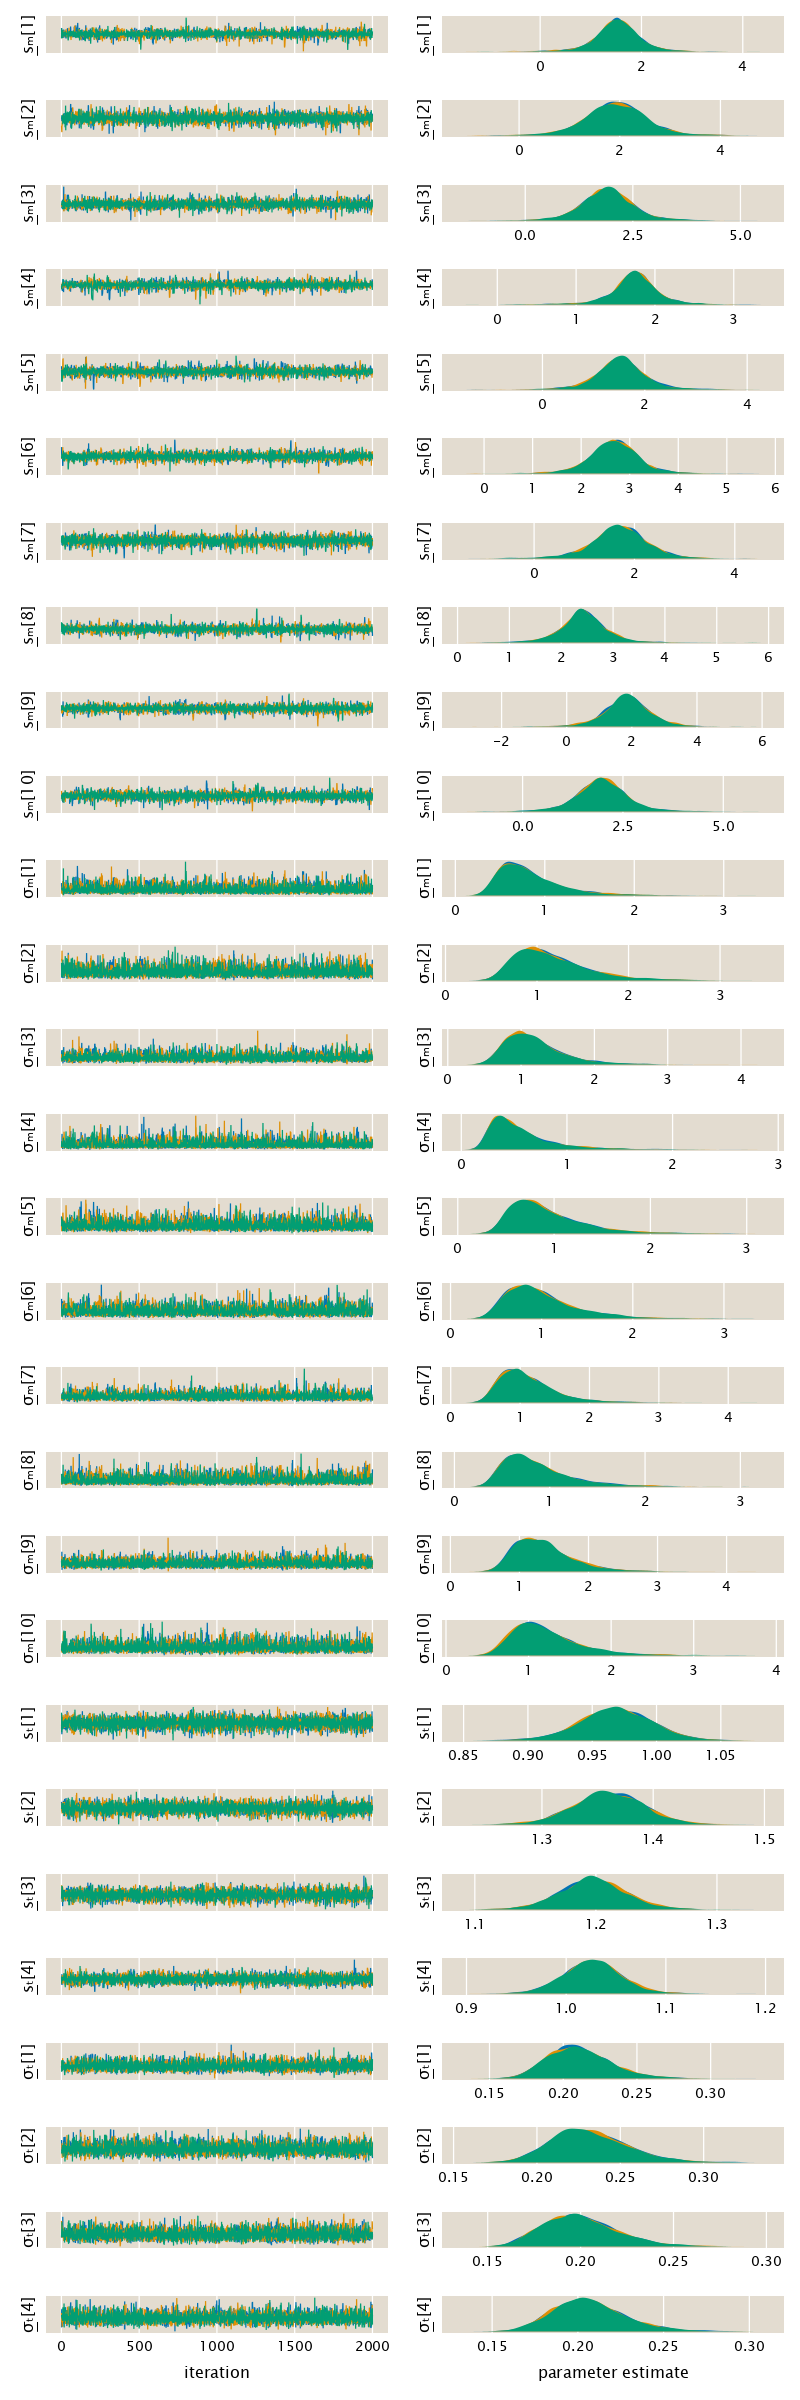

In [19]:
# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(resolution=(800, 2400))

BayesFitness.viz.mcmc_trace_density!(fig, chain)

fig